In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 16})

In [2]:
NYC_df=pd.read_csv("AB_NYC_2019.csv")
NYC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [3]:
NYC_df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [4]:
#get rid of redundant or incomplete columns
NYC_df.drop(columns=["name", "host_name", "last_review", "reviews_per_month"], inplace=True)
NYC_df.drop(NYC_df[NYC_df.price==0].index, inplace=True)

## Quantitative analysis
- Distribution of room types in the 5 boroughs
- Distribution of the price wrt room type and borough

<AxesSubplot:xlabel='neighbourhood_group', ylabel='Count'>

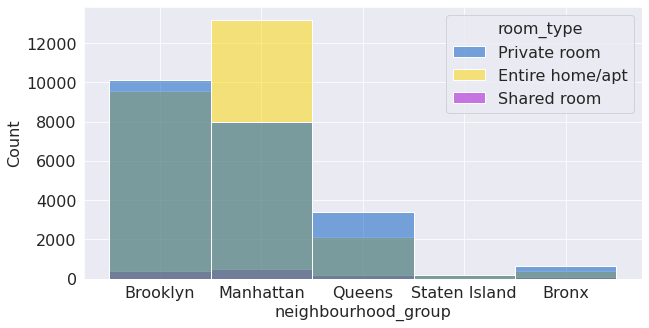

In [5]:
plt.subplots(figsize=(10,5))
sns.histplot(data=NYC_df, x="neighbourhood_group", hue="room_type", palette="prism")

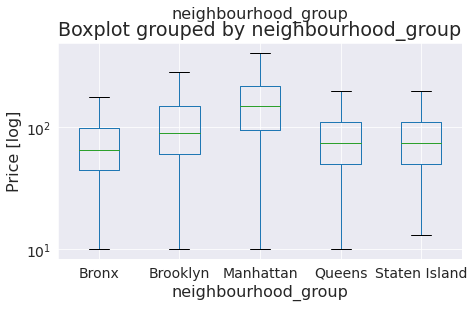

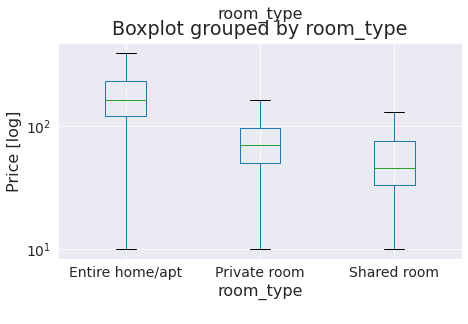

In [6]:
for c in ["neighbourhood_group", "room_type"]:
    NYC_df.boxplot("price", by=c, figsize=(7,4),fontsize=14, showfliers=False)
    plt.title("{}\n".format(c),fontsize=16)
    plt.xlabel("{}\n".format(c), fontsize=16)
    plt.ylabel("Price [log]", fontsize=16)
    plt.yscale("log")

Expectedly, supply is higher where demand is: Brooklyn and Manhattan are must-sees, both NYC airports are at Queens while Staten Island is kind of out of town. Prices distribute accordingly (roughly). In wealthier neighborhoods there is also an higher supply of private apartments, which cost the most as the second boxplot shows.

## Correlation between the average price \& the home-supply per neighborhood

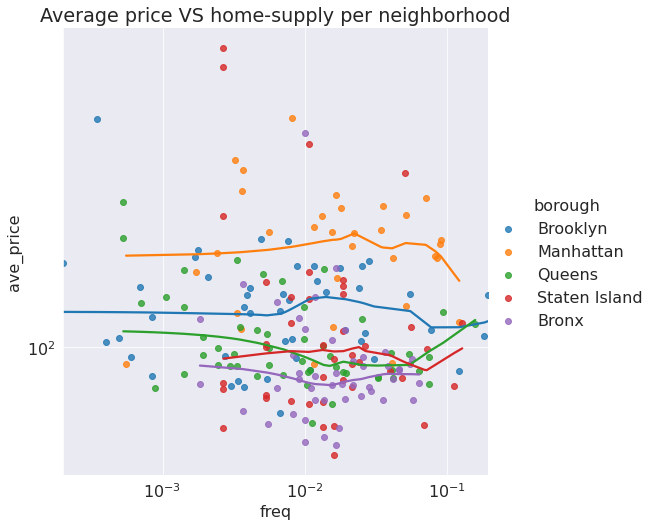

In [7]:
NYC_mean=NYC_df.groupby("neighbourhood")["price"].mean()
NYC_entries=NYC_df.neighbourhood.value_counts().reset_index()
NYC_entries.columns=["neighbourhood", "number_entries"]
NYC_entries_borough=NYC_df.neighbourhood_group.value_counts().reset_index()
NYC_entries_borough.columns=["neighbourhood_group", "number_entries_borough"]
neigh=[]
i=0
j=0
for x in NYC_df.neighbourhood_group.unique():
    for y in NYC_df[NYC_df.neighbourhood_group==x].neighbourhood.unique():
        neigh.append([x,y])

NYC_neigh=pd.DataFrame(neigh, columns=["neighbourhood_group", "neighbourhood"])
NYC_neigh=NYC_neigh.merge(NYC_mean, on="neighbourhood")
NYC_neigh=NYC_neigh.merge(NYC_entries, on="neighbourhood")
NYC_neigh=NYC_neigh.merge(NYC_entries_borough, on="neighbourhood_group")

NYC_neigh.rename(columns={"price" : "ave_price", "neighbourhood_group" : "borough"}, inplace=True)
NYC_neigh["freq"]=NYC_neigh.number_entries/NYC_neigh.number_entries_borough

#plt.subplots(figsize=(10,5))
ax=sns.lmplot(data=NYC_neigh, x="freq", y="ave_price", hue="borough", lowess=True, legend_out=True, height=7);
ax.set( xscale="log", yscale="log", title="Average price VS home-supply per neighborhood")

There seems to be no correlation between the two factors.
## Correlation matrix

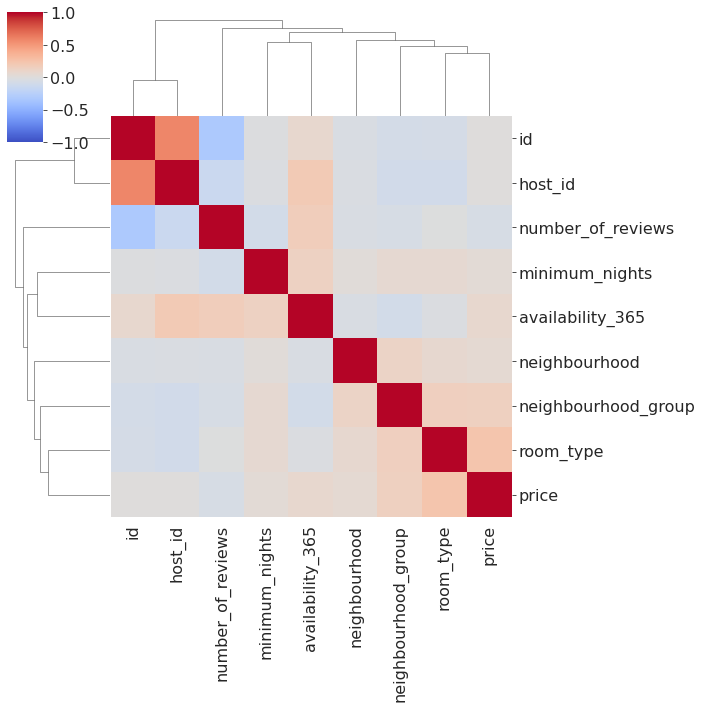

In [44]:
replace_borough={"neighbourhood_group": {"Staten Island": 1, "Bronx": 2, "Queens": 3, "Brooklyn": 4, "Manhattan": 5}}
replace_room={"room_type": {"Entire home/apt": 3, "Private room": 2, "Shared room": 1}}
labels_neigh=NYC_df.neighbourhood.astype("category").cat.categories.tolist()
replace_neigh={"neighbourhood": {k: v for (k,v) in zip(labels_neigh, list(range(1,len(labels_neigh)+1)))}}

NYC_df_cp=NYC_df.copy()
NYC_df_cp.replace(replace_borough, inplace=True)
NYC_df_cp.replace(replace_room, inplace=True)
NYC_df_cp.replace(replace_neigh, inplace=True)
NYC_df_cp.drop(columns=["longitude", "latitude", "calculated_host_listings_count"], inplace=True)

sns.clustermap(NYC_df_cp.corr(), vmin=-1, vmax=1, cmap="coolwarm")

- the categories that most affect the price seem to be the room type and the borough. It appears that there is not a significant relation between prices and neighbourhoods.
- There seems to be no correlation between prices and host id, hence there is no visible effect of price inflation or deflaction by a significant number of hosts (at least not visible at a town-wide scale).
- The strong correlation between the host id and the id of the room is probably due to how the AirBnb algorithm assigns ids.
- It appears there is a significant correlation between the number of reviews and the availability all-year-long of the apartment (perhaps not surprisingly), however it looks like only specific hosts are prone to rent their homes for a longer period (probabily due to house-rental not being their main source of income). However, such factors do not seem to influence the price.

## Distribution of prices wrt room types

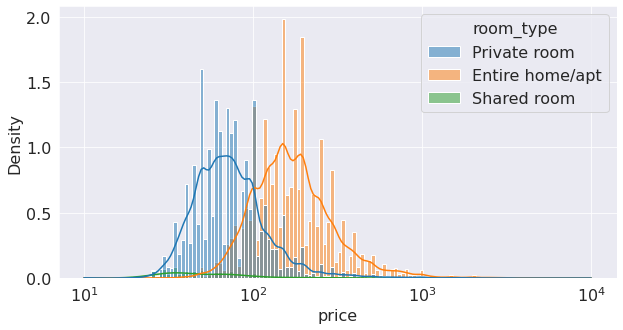

In [55]:
plt.subplots(figsize=(10,5))
sns.histplot(NYC_df, x="price", hue="room_type", stat="density", log_scale=(True,False), kde=True);

In [9]:
import scipy.stats 
a,b,c=scipy.stats.alpha.fit(NYC_df[NYC_df.room_type=="Private room"]["price"], floc=0)
d,e,f=scipy.stats.alpha.fit(NYC_df[NYC_df.room_type=="Entire home/apt"]["price"], floc=0)

/home/alessandro/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


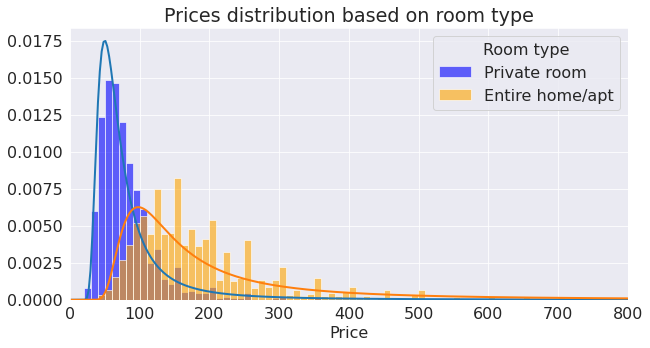

In [10]:
xmin=0
xmax=800
x = np.linspace(xmin,xmax,300)

plt.subplots(figsize=(10,5))
W1=scipy.stats.alpha(a,b,c) 
plt.plot(x, W1.pdf(x), linewidth=2)
W2=scipy.stats.alpha(d,e,f) 
plt.plot(x, W2.pdf(x), linewidth=2)

NYC_df[NYC_df.room_type=="Private room"].price.hist(bins=1000, density=True, label="Private room", color="blue", alpha=0.6)
NYC_df[NYC_df.room_type=="Entire home/apt"].price.hist(bins=1000, density=True, label="Entire home/apt", color="orange", alpha=0.6)

plt.xlim((xmin,xmax))
plt.xlabel("Price")
plt.title("Prices distribution based on room type")
plt.legend(title="Room type")
plt.show()

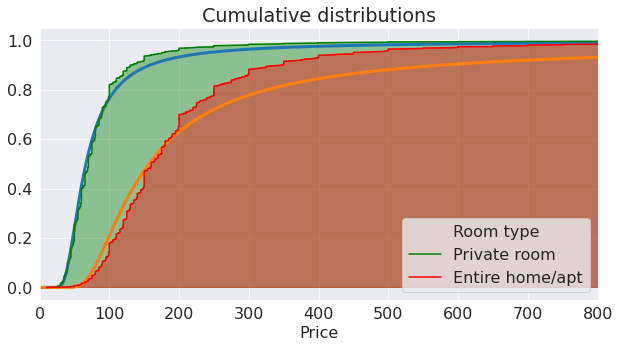

In [11]:
priv=NYC_df[NYC_df.room_type=="Private room"].price
apt=NYC_df[NYC_df.room_type=="Entire home/apt"].price
priv1=np.sort(priv)
apt1=np.sort(apt)
idx1 = [ i/len(priv1) for i in range(len(priv1))]
idx2 = [ i/len(apt1) for i in range(len(apt1))]

plt.subplots(figsize=(10,5))
plt.plot(x, W1.cdf(x), linewidth=3)
plt.plot(x, W2.cdf(x), linewidth=3)
plt.plot(priv1, idx1, label="Private room", color="green")
plt.fill_between(priv1, idx1, alpha=0.4, color="green")
plt.plot(apt1, idx2, label="Entire home/apt", color="red")
plt.fill_between(apt1, idx2, alpha=0.4, color="red")
plt.xlabel("Price")
plt.title("Cumulative distributions")
plt.legend(frameon=True, title="Room type")
plt.xlim((xmin,xmax))
plt.show()

In [12]:
y1=priv.to_numpy().astype(np.float)
scipy.stats.kstest(y1, lambda x: scipy.stats.alpha.cdf(x, a, loc=b, scale=c))


KstestResult(statistic=0.07003902002358686, pvalue=1.202867491960583e-95)

In [73]:
y2=apt.to_numpy()
scipy.stats.kstest(y2, lambda x: scipy.stats.alpha.cdf(x, d, loc=e, scale=f))

KstestResult(statistic=0.10459088552490603, pvalue=1.872390366436205e-242)

The hypothesis that prices for different room-types are $\alpha$-distributed is rejected.